In [1]:
# Model 1 is a very simple model with just embedding, GELU and unembedding layers
# The in b/w attention and MLP layers are not there
# this is called zero layer transformers

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import requests
import re
import string

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
#GPT4s tokenizer
import tiktoken
tokenizer = tiktoken.get_encoding('cl100k_base')

Hyperparameters

In [6]:
# data hyperparas
seq_len = 8 # aka context length
stride = 2
n_vocab = tokenizer.n_vocab

#model hyperparas
embed_dim = 2**6 #64

batch_size=5



get data

In [8]:
# tokenize the text
text = requests.get('https://www.gutenberg.org/files/35/35-0.txt').text

# text needds to be pytorch tensors
tokens = tokenizer.encode(text)
print(f'Varibale "tokens" is type {type(tokens)} and has {len(tokens)}')

#convert to pytorch
tmTokens = torch.tensor(tokens)
print(f'Varibale "tmTokens" is type {type(tmTokens)} and has {len(tmTokens)}')


Varibale "tokens" is type <class 'list'> and has 43053
Varibale "tmTokens" is type <class 'torch.Tensor'> and has 43053


In [13]:
tmTokens

tensor([12488, 21673,  3083,  ...,  1758, 17601,   319])

DataLoader

In [49]:
# create a class for a dataset
class TokenDataset(Dataset):
    def __init__(self, tokens, seq_length=8, stride=4):

        # init
        self.inputs = []
        self.targets = []
        

        # overlapping seq of context_length
        for i in range(0,len(tokens)-seq_length,stride):
            # get context tokens and append to lists
            self.inputs.append(tokens[i : i+seq_length])
            self.targets.append(tokens[i+1 : i+seq_length+1])

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self,idx):
        return self.inputs[idx], self.targets[idx]

# create an instance
token_dataset = TokenDataset(tmTokens, seq_len, stride)

print(token_dataset[12345])
print(tokenizer.decode(token_dataset[12345][0].tolist()))

(tensor([1820,  832,  358, 1047, 3970, 3485, 5015,  304]), tensor([ 832,  358, 1047, 3970, 3485, 5015,  304,  279]))
the one I had seen above ground in


create the model

In [57]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        #embedding matrix
        self.embedding = nn.Embedding(n_vocab, embed_dim)

        #unembedding(linear layer)
        self.gelu = nn.GELU() # non linearity
        self.finalLinear = nn.Linear(embed_dim, n_vocab, bias = False) # unembed layer

    def forward(self, tokx):

        #fwd pass
        x = self.embedding(tokx) # [batch, token, embed_dim]
        x = self.gelu(x)
        x = self.finalLinear(x) # [batch, token, vocab_size]

        # x is the raw model outputs aka logits
        # no softmax here
        return x

    def generate(self, tokx, n_new_tokens=30):
        # tokx is [batch, tokens]

        for _ in range(n_new_tokens):

            # get predictions
            x = self(tokx) # reference to the model itself (i.e feed fwd sweep for tokx

            # extract the final token to predict the next
            x = x[:,-1,:]  # [batch, vocab_size]
            

            # apply softmaxt to get prob values over all tokens in vocab
            probs = F.softmax(x,dim=1)

            #probabilistically sample from distbn
            tokx_next = torch.multinomial(probs, num_samples=1) # [batch,1]
            # print("next token:",tokenizer.decode([tokx_next]))
            #append 
            tokx = torch.cat((tokx, tokx_next),dim=1) #[batch, (tokens+1)]
        return tokx
        

In [59]:
# run the model

#new isntacne of model
model = Model()

# get some data
X,y = token_dataset[12345]

#proces the tokens (fwd pass)
out = model(X)

print(X.shape)
print(y.shape)
print(out.shape)  # [tokens,vocab_size]

# this now uses a batch sizze of 1

torch.Size([8])
torch.Size([8])
torch.Size([8, 100277])


In [36]:
print(X)
print(y)
print(out)

tensor([1820,  832,  358, 1047, 3970, 3485, 5015,  304])
tensor([ 832,  358, 1047, 3970, 3485, 5015,  304,  279])
tensor([[-0.3619, -0.1404,  0.1821,  ..., -0.1177, -0.8911,  0.6848],
        [-0.5637,  0.6816,  0.5493,  ...,  0.2104, -0.0939, -0.0086],
        [-0.1809, -0.1076,  0.1216,  ...,  0.4823, -0.0998, -0.3695],
        ...,
        [ 0.2502,  0.3293,  0.6087,  ...,  0.1539, -0.1881, -0.3734],
        [-0.2986, -0.4043,  0.1364,  ...,  0.3036, -0.2566, -0.3018],
        [ 0.1428, -0.2609, -0.0068,  ..., -0.0275,  0.0929, -0.1936]],
       grad_fn=<MmBackward0>)


[Text(0.5, 1.0, 'Raw model ouputs'),
 Text(0.5, 0, 'token index;'),
 Text(0, 0.5, 'Value')]

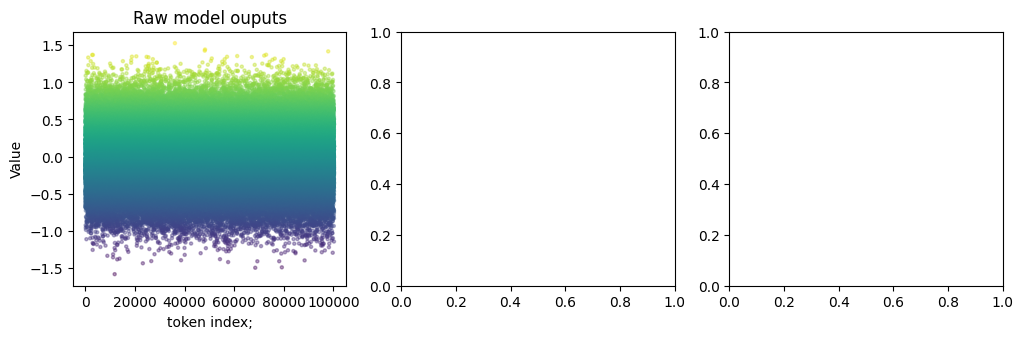

In [23]:
# visualize model output

#get the last output token and all of the logit values for that position
final = out[-1,:].detach()
softmaxFinal = torch.exp(final) / torch.exp(final).sum()


_,axs = plt.subplots(1,3,figsize = (12,3.3))

#show the logits (raw logit coloring throughout)
axs[0].scatter(range(len(final)), final, s=5, marker='o', c=final, alpha=.4)
axs[0].set(title='Raw model ouputs',xlabel = 'token index;',
           ylabel='Value')

generate text

In [38]:
# some text
generated_tokens = model.generate(X.unsqueeze(dim=0),10) #unsqueeze bcoz 
# generate() expects first dimension in batches

tokenizer.decode(generated_tokens[0].tolist())

next token: úmero
next token:  Croatian
next token:  Ten
next token:  Gregory
next token: minus
next token: �
next token: manager
next token:  Classic
next token:  icing
next token:  Camp


'the one I had seen above ground inúmero Croatian Ten Gregoryminus�manager Classic icing Camp'

In [40]:
# repeat multiple times from same starting point

for i in range(5):
    # new tokens
    tokz = model.generate(X.unsqueeze(dim=0),10)
    tokz = tokz[0].tolist()

    print(f'---Run {i+1}---')
    print(tokenizer.decode(tokz))
    print('\n\n')

next token: kontakte
next token: .startswith
next token: Anderson
next token:  earnings
next token: ev
next token:  Sexe
next token: .layoutControlItem
next token:  spicy
next token: disp
next token: Buttons
---Run 1---
the one I had seen above ground inkontakte.startswithAnderson earningsev Sexe.layoutControlItem spicydispButtons



next token:  tung
next token: Gateway
next token: 423
next token:  beau
next token:  о
next token: CompanyId
next token: .loc
next token:  pancreatic
next token: RegularExpression
next token: /operator
---Run 2---
the one I had seen above ground in tungGateway423 beau оCompanyId.loc pancreaticRegularExpression/operator



next token: =text
next token:  bond
next token:  turnaround
next token:  dec
next token:  Shir
next token: mercial
next token:  harmon
next token:  können
next token: .Request
next token:  StringTokenizer
---Run 3---
the one I had seen above ground in=text bond turnaround dec Shirmercial harmon können.Request StringTokenizer



next token

In [41]:
# all the runs use the same starting point
# but because we use multinomial function we get different results each run

# IMPPPPPP!!!!1
# this is the mechanism where every time you ask Chatgpt
# the same question, the answer slightly differs

In [42]:
# above was for one batch
# now generate text in batches


In [62]:
# we need a data loader
dataloader = DataLoader(
    token_dataset,
    batch_size = batch_size,
    shuffle=True,
    drop_last=True
)


X,y = next(iter(dataloader))
print(f'Inputs ({batch_size} batches X {seq_len} tokens):')
print(X)

# batches can be calculated in parallel
#so comp efficient
# it smooths out learning---> form of regularisation
    # loss from each token seq gets averaged together across batch

Inputs (5 batches X 8 tokens):
tensor([[  358,  1518,   433,  1457,  2476,   568,  1071,  1306],
        [  287,   856,  7693,   323,  5115,   319, 49975,  1752],
        [ 3245,   574,  2867,   319,   268,  1409,   311,   856],
        [ 2949,  5662,    13,   358, 14980, 72221,   520,   279],
        [ 1047, 61014,  1523,  1139,   319, 42511, 10296, 18304]])


In [63]:
out = model(X) 
print(out.shape)  # [batch,tokens, vocab]
print('\n',out)

torch.Size([5, 8, 100277])

 tensor([[[ 4.5759e-01,  3.1692e-01, -3.4245e-01,  ...,  9.4278e-02,
           4.7340e-01,  7.5811e-01],
         [ 4.8996e-02,  3.2170e-01,  1.9465e-02,  ..., -6.9279e-02,
           5.1665e-02,  3.4921e-01],
         [-1.9055e-02, -1.2173e-01,  6.0224e-02,  ...,  5.6097e-01,
          -1.7061e-01,  4.0237e-01],
         ...,
         [ 1.3042e-01,  4.8617e-01, -2.5470e-01,  ...,  1.6234e-01,
          -6.3333e-02,  2.7356e-01],
         [-1.6513e-01,  2.2453e-01, -8.4495e-03,  ..., -1.8443e-01,
          -2.1459e-01,  2.0184e-01],
         [ 3.8392e-01,  6.1252e-01,  6.4188e-01,  ...,  7.7746e-01,
           2.6971e-02,  1.1986e-01]],

        [[ 2.5031e-01,  3.0938e-01,  1.9575e-02,  ...,  2.8268e-01,
           1.2785e-01,  5.8705e-02],
         [-1.5699e-01,  4.3497e-01,  4.4603e-01,  ...,  6.2038e-02,
           1.9299e-01,  4.5878e-01],
         [-1.9652e-01, -2.5522e-01,  3.1290e-01,  ..., -3.8922e-01,
          -1.1959e-01,  3.4298e-01],
         .

In [64]:
# generate some data
gen_tokens = model.generate(X)
print(gen_tokens.shape) # [batch, (tokens+n_new_tokens)]

torch.Size([5, 38])
